In [1]:
#%pip install -q git+https://github.com/keras-team/keras-nlp.git --upgrade
%pip install transformers


In [7]:
#from google.colab import drive
#drive.mount('/content/gdrive')

In [2]:
import pandas as pd
import json

from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.keras.utils import plot_model
from tensorflow.keras import Input, Model, Sequential, regularizers
from tensorflow.keras.layers import concatenate,TimeDistributed, Concatenate, GRU, Activation, SpatialDropout2D, Dropout, Flatten,SeparableConv1D, Dense, SimpleRNN, LSTM, Conv1D, Reshape,MaxPooling1D, Conv2D, Reshape,MaxPooling2D, Permute,Bidirectional, BatchNormalization, DepthwiseConv2D, GlobalMaxPooling2D
from tensorflow.keras.layers import concatenate, Embedding
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping,Callback#training callbacks
from tensorflow.keras import optimizers
from tensorflow.keras import models
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split
from ast import literal_eval

import matplotlib.pyplot as plt
import numpy as np

import transformers


c:\Users\jeday\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
#from google.colab import drive
#drive.mount('/content/drive')

In [3]:
folder_path = './'

In [4]:
data_path = folder_path + 'data-set-rows.json'
import codecs

with codecs.open(data_path, "r", "utf_8_sig") as data_file:
  data_text = data_file.read()  
  # убираем BOM-символ из json файла
  data = json.loads(data_text.lstrip('\ufeff'))
  df = pd.DataFrame(data)

print('Total rows:', len(df))
print('Duplicates:', sum(df["TextLine"].duplicated()))

Total rows: 2043
Duplicates: 415


drop duplicates

In [5]:
df = df[~df["TextLine"].duplicated()]
print('Deduplicated rows:', len(df))

Deduplicated rows: 1628


In [6]:
#print(df.info)
print(df.shape)
print(df.columns.values)
print(df.head(20))

(1628, 2)
['TextLine' 'Parameters']
                                             TextLine Parameters
0                              пневмония, КТ-2, ДН 0         [0]
2   дыхание, першение в горле, головная боль, одыш...        [0]
3   Жалобы: слабость общая умеренная, сухой со сви...        [0]
4   Жалобы: слабость общая умеренная, сухой, одышк...        [0]
5   Жалобы: слабость общая умеренная, сухой, одышк...        [0]
6   Жалобы: слабость общая умеренная,кашель сухой,...        [0]
7   Лейкоциты (WBC) 11.56 10Е9/л (3.80 - 11.80) Ли...        [1]
8   10Е9/л (1.70 - 7.60) Базофилы # (Bas) 0.04 10Е...         []
11  Лейкоциты (WBC) 14.32 10Е9/л (3.80 - 11.80) Ли...        [1]
13                         одышка при фн выраженная.         [0]
14  одышка при фн выраженная, к ночи чувство распи...        [0]
15  одышка в покое, к ночи чувство распирание в го...        [0]
16  одышка в покое, не может спать на животе ввиду...        [0]
18  Лейкоциты (WBC) 9.23 10Е9/л (3.80 - 11.80) Лим... 

In [7]:
#change labeling style
for i in range(len(df)):
  #нет параметров
  if (df.iloc[i]['Parameters'])==[]:
    df.iloc[i]['Parameters']=0
  #одышка при фн
  if (df.iloc[i]['Parameters'])==[0]:
    df.iloc[i]['Parameters']=1
  #лимфоциты абс
  if (df.iloc[i]['Parameters'])==[1]:
    df.iloc[i]['Parameters']=2



In [8]:
#print(df.info)
print(df.shape)
print(df.columns.values)
print(df.head(20))

(1628, 2)
['TextLine' 'Parameters']
                                             TextLine Parameters
0                              пневмония, КТ-2, ДН 0           1
2   дыхание, першение в горле, головная боль, одыш...          1
3   Жалобы: слабость общая умеренная, сухой со сви...          1
4   Жалобы: слабость общая умеренная, сухой, одышк...          1
5   Жалобы: слабость общая умеренная, сухой, одышк...          1
6   Жалобы: слабость общая умеренная,кашель сухой,...          1
7   Лейкоциты (WBC) 11.56 10Е9/л (3.80 - 11.80) Ли...          2
8   10Е9/л (1.70 - 7.60) Базофилы # (Bas) 0.04 10Е...          0
11  Лейкоциты (WBC) 14.32 10Е9/л (3.80 - 11.80) Ли...          2
13                         одышка при фн выраженная.           1
14  одышка при фн выраженная, к ночи чувство распи...          1
15  одышка в покое, к ночи чувство распирание в го...          1
16  одышка в покое, не может спать на животе ввиду...          1
18  Лейкоциты (WBC) 9.23 10Е9/л (3.80 - 11.80) Лим... 

In [9]:
#print values
def get_classes_counts(data, classes_num):
  for i in range(classes_num):
    class_count = len(list(filter(lambda x: x == i, data)))
    print("Class ", i, " = ", class_count)

In [10]:
#preprocess the data
import re
to_exclude = '»«$&()*+-/<=>@[\\]^_`{|}~\t\n'#excluded symbols
to_tokenize = '.,:!?";%#'#processed symbols

data_length = len(df.index)

for i in range(data_length):
    df.iloc[i]["TextLine"]=re.sub(r'(['+to_tokenize+'])', r' \1 ', df.iloc[i]['TextLine'])

    if i%100==0:
      print(df.iloc[i])

TextLine        пневмония ,  КТ-2 ,  ДН 0 
Parameters                               1
Name: 0, dtype: object
TextLine      гемоглобина (MCHC) 310 . 00 г/л (323 . 00 - 35...
Parameters                                                    2
Name: 112, dtype: object
TextLine      Основной :  Коронавирусная инфекция ,  вызванн...
Parameters                                                    0
Name: 218, dtype: object
TextLine       Жалобы :  кашель малопродуктивный .  боль в н...
Parameters                                                    0
Name: 338, dtype: object
TextLine       Доступные и значимые данные лабораторных и ин...
Parameters                                                    0
Name: 446, dtype: object
TextLine      На протяжении обоих легких участки уплотнения ...
Parameters                                                    1
Name: 567, dtype: object
TextLine      Диагноз :  Основное заболевание Короновирусная...
Parameters                                                    

In [11]:
text_subframe = df["TextLine"]
max_len = 4500
num_words = 6000

tokenizer_text = transformers.BertTokenizer.from_pretrained("bert-base-uncased", do_lower_case=True)
test_str = "тестовая строка 1"
test_str1 = "fasdfsa fdfs "
encoded = tokenizer_text.encode(text=test_str, text_pair=test_str1, max_length=max_len, add_special_tokens=True, padding=True, truncation=True)
decoded = tokenizer_text.decode(token_ids=encoded, skip_special_tokens=False, clean_up_tokenization_spaces = True)

print(tokenizer_text)
print(encoded)
print(decoded)
#tokenizer_text.fit_on_texts(text_subframe)

#tokenizer_text.word_index


BertTokenizer(name_or_path='bert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})
[101, 1197, 15290, 29747, 22919, 19259, 10260, 17432, 1196, 22919, 16856, 14150, 28598, 1015, 102, 6904, 16150, 10343, 2050, 1042, 20952, 2015, 102]
[CLS] тестовая строка 1 [SEP] fasdfsa fdfs [SEP]


In [12]:
sequences_text = tokenizer_text.batch_encode_plus(text_subframe.tolist(), max_length=6000, add_special_tokens=True, padding=True, truncation=True)
print(sequences_text["input_ids"][0])
print(tokenizer_text.decode(sequences_text["input_ids"][0]))
print(sequences_text["attention_mask"][0])
print(sequences_text["token_type_ids"][0])

[101, 1194, 18947, 15290, 25529, 29745, 14150, 18947, 23483, 1010, 1189, 22919, 1011, 1016, 1010, 1184, 18947, 1014, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [13]:
max_text_len = 300
#sequences_padded = pad_sequences(sequences_text, maxlen=max_text_len, padding='pre', truncating='pre')#changed to pre

#params_data = df["Parameters"].apply(lambda x: [0] if x == [] else x)
params_data = df["Parameters"]

print(len(sequences_text["input_ids"][814]))
#print(len(sequences_padded[814]))
print(type(params_data))

3534
<class 'pandas.core.series.Series'>


In [14]:
max_len = 4500

In [15]:
def multilabel_encoding(labels_seq, num_classes):
        buf=[]
        labels_seq_list = list(labels_seq)
        for i in range(len(labels_seq_list)):
            buf_row=[]
            for j in range(num_classes):
                buf_row.append(0)

            if labels_seq_list[i] != 0:
                buf_row[labels_seq_list[i]-1] = 1 
            buf_row = np.asarray(buf_row)
            buf.append(buf_row)
        buf = np.asarray(buf)
        return buf

params_encoded = multilabel_encoding(params_data, 2)
print(params_encoded)

[[1 0]
 [1 0]
 [1 0]
 ...
 [1 0]
 [1 0]
 [0 1]]


In [16]:
test_split = 0.2

seq_train_df, seq_testval_df, params_train_df, params_testval_df = train_test_split(
    text_subframe,
    params_encoded,
    test_size=test_split,
    random_state=42,
    shuffle=True
    #stratify=params_data.values
)

print("training set of sequences: ", len(seq_train_df))
print("test set of sequences:", len(seq_testval_df))
print("training set of params", len(params_train_df))
print("test set of params", len(params_testval_df))


training set of sequences:  1302
test set of sequences: 326
training set of params 1302
test set of params 326


In [17]:
seq_val_df, seq_test_df, params_val_df, params_test_df = train_test_split(
    seq_testval_df,
    params_testval_df,
    test_size=0.5,
    random_state=42,
    shuffle=True
)

In [18]:
print(params_encoded)

[[1 0]
 [1 0]
 [1 0]
 ...
 [1 0]
 [1 0]
 [0 1]]


In [19]:
import random

def DG_customV2 (X_data, Y_data, batch_size, use_DA):
    tokenizer = transformers.BertTokenizer.from_pretrained(
            "bert-base-uncased", do_lower_case=True
        )

    input_data = X_data.tolist()

    vocab_size=len(tokenizer.get_vocab())

    full_set_size=len(input_data)/batch_size
    full_set_size=int(full_set_size)
    full_set_size=full_set_size*batch_size

    counter=0
    seq_arg_part=0.2
    
    while True:
            selected_input_data=[]
            selected_output_data=[]

            for i in range(batch_size):

                selected_input_data.append(input_data[counter])               
                selected_output_data.append(Y_data[counter])
                counter+=1
                if counter==full_set_size:
                    counter=0
            
            # batch_text=[]
            # for i in range(len(selected_input_data)):
            #   buf=[]
                # buf.append(selected_input_data[i])
                # buf.append(selected_input_data[i])
            #   batch_text.append(buf)


    
            encoded = tokenizer.batch_encode_plus(
                batch_text_or_text_pairs=selected_input_data,
                add_special_tokens=True,
                max_length=max_len,
                return_attention_mask=True,
                return_token_type_ids=True,
                pad_to_max_length=True,
                return_tensors="tf",
            )

            # Convert batch of encoded features to numpy array.
            input_ids = np.asarray(encoded["input_ids"], dtype="float32")
            attention_masks = np.asarray(encoded["attention_mask"], dtype="int32")
            token_type_ids = np.asarray(encoded["token_type_ids"], dtype="int32")
            
            #add noise 
            if use_DA==True:
              for i in range(len(input_ids)):
                max_rand_level=int(seq_arg_part*len(input_ids[i]))
                random_level=random.randint(1,max_rand_level)
                for j in range(random_level):
                  replaced_idx = random.randint(0,len(input_ids[i])-1)
                  new_value = random.randint(0,vocab_size-1)
                  input_ids[i][replaced_idx] = new_value

            labels_out=np.array(selected_output_data, dtype="int32") 
            yield [input_ids, attention_masks, token_type_ids], labels_out

In [20]:
batch_size = 2

train_DG = DG_customV2(seq_train_df, params_train_df, batch_size, False)
test_DG = DG_customV2(seq_test_df, params_test_df, batch_size, False)
val_DG = DG_customV2(seq_val_df, params_val_df, batch_size, False)

nb_validation_samples=int(len(params_val_df)/batch_size)
nb_test_samples=int(len(params_test_df)/batch_size)
nb_train_samples=int(len(params_val_df)/batch_size)

a=next(train_DG)
print(a[0])
print(a[1])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
c:\Users\jeday\AppData\Local\Programs\Python\Python39\lib\site-packages\transformers\tokenization_utils_base.py:2346: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


[array([[  101.,  1194., 29436., ...,     0.,     0.,     0.],
       [  101.,  1190., 15290., ...,     0.,     0.,     0.]],
      dtype=float32), array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]]), array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])]
[[0 0]
 [0 1]]


In [23]:
get_classes_counts(params_train_df, 3)

Class  0  =  511
Class  1  =  636
Class  2  =  155


In [96]:
train_data[6]
#indexes = np.arange(len(text_subframe))
#idx = 0
#indexess = indexes[idx * 10 : (idx + 1) * 10]
#print(indexess)
#print(text_subframe.iloc[indexess])


([array([[  101.,  1194., 19259., ...,     0.,     0.,     0.],
         [  101.,  1196.,  1180., ...,     0.,     0.,     0.],
         [  101.,  1202., 29742., ...,     0.,     0.,     0.],
         ...,
         [  101.,  1197., 14150., ...,     0.,     0.,     0.],
         [  101.,  1199., 14150., ...,     0.,     0.,     0.],
         [  101.,  1184., 14150., ...,     0.,     0.,     0.]],
        dtype=float32),
  array([[1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0],
         ...,
         [1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0]]),
  array([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]])],
 array([[1, 0],
        [0, 1],
        [0, 0],
        [1, 0],
        [1, 0],
        [0, 1],
        [1, 0],
        [0, 0],
        

In [29]:
import tensorflow as tf

In [21]:
num_attention_heads=12 #def 12
hidden_size=768 # def 768 for pretrained is fixed. in theory, it can be hidden_size = num_attention_heads *n. for example 756 can be used for untrained model
num_hidden_layers=12#def 12
intermediate_size =3072#def 3072
vocab_size = 30522#def 30522
type_vocab_size = 2

# Encoded token ids from BERT tokenizer.
inputs_ids = tf.keras.layers.Input(
    shape=(max_len), dtype=tf.int32, name="input_ids"
)
# Attention masks indicates to the model which tokens should be attended to.
attention_masks = tf.keras.layers.Input(
    shape=(max_len,), dtype=tf.int32, name="attention_masks"
)
# Token type ids are binary masks identifying different sequences in the model.
token_type_ids = tf.keras.layers.Input(
    shape=(max_len,), dtype=tf.int32, name="token_type_ids"
)
# config = transformers.BertConfig (hidden_size=hidden_size, num_hidden_layers=num_hidden_layers,
#                                       num_attention_heads=num_attention_heads, intermediate_size=intermediate_size,
#                                       vocab_size=vocab_size, type_vocab_size=type_vocab_size )
                                    #output_hidden_states=True)
#use empty untrained model
#bert_model = transformers.TFBertModel(config=config)
#empty pretrained model
#bert_model = transformers.TFBertModel.from_pretrained("bert-base-uncased", config=config)#
# Loading pretrained BERT model.
bert_model = transformers.TFBertModel.from_pretrained("bert-base-uncased")#
# Freeze the BERT model to reuse the pretrained features without modifying them.
bert_model.trainable = False
#bert_output = bert_model.bert(input_ids, attention_mask=attention_masks, token_type_ids=token_type_ids)
bert_output = bert_model.bert({"input_ids": inputs_ids,
                               'attention_mask': attention_masks, 
                                'token_type_ids': token_type_ids
                               })
#sequence_output = bert_output.last_hidden_state
#pooled_output = bert_output.pooler_output
# Add trainable layers on top of frozen layers to adapt the pretrained features on the new data.
bi_lstm = tf.keras.layers.Bidirectional(
    tf.keras.layers.LSTM(64, return_sequences=True)
)(bert_output[0])#pooled_output sequence_output
# Applying hybrid pooling approach to bi_lstm sequence output.
avg_pool = tf.keras.layers.GlobalAveragePooling1D()(bi_lstm)
max_pool = tf.keras.layers.GlobalMaxPooling1D()(bi_lstm)
concat = tf.keras.layers.concatenate([avg_pool, max_pool])
dropout = tf.keras.layers.Dropout(0.3)(concat)
output = tf.keras.layers.Dense(2, activation="sigmoid")(dropout)
model = tf.keras.models.Model(
    inputs=[inputs_ids,attention_masks,token_type_ids] , outputs=output
)
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss="binary_crossentropy",
    metrics=[tf.keras.metrics.MeanIoU(num_classes=2, name='mean_io_u')],
)

model.summary()

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_masks (InputLayer)   [(None, 4500)]       0           []                               
                                                                                                  
 input_ids (InputLayer)         [(None, 4500)]       0           []                               
                                                                                                  
 token_type_ids (InputLayer)    [(None, 4500)]       0           []                               
                                                                                                  
 bert (TFBertMainLayer)         TFBaseModelOutputWi  109482240   ['attention_masks[0][0]',        
                                thPoolingAndCrossAt               'input_ids[0][0]',          

In [42]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [22]:
check_path= folder_path + "model-without-empty-param-checkpoints-bert"
check_path

'./model-without-empty-param-checkpoints-bert'

Epoch 1/20
81/81 [==============================] - ETA: 0s - loss: 0.4275 - mean_io_u: 0.3688

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


INFO:tensorflow:Assets written to: .\model-without-empty-param-checkpoints-bert\assets


INFO:tensorflow:Assets written to: .\model-without-empty-param-checkpoints-bert\assets


81/81 [==============================] - 845s 10s/step - loss: 0.4275 - mean_io_u: 0.3688 - val_loss: 0.3776 - val_mean_io_u: 0.3534
Epoch 2/20


c:\Users\jeday\AppData\Local\Programs\Python\Python39\lib\site-packages\transformers\tokenization_utils_base.py:2346: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


81/81 [==============================] - 552s 7s/step - loss: 0.3527 - mean_io_u: 0.3549 - val_loss: 0.3329 - val_mean_io_u: 0.3534
Epoch 3/20
81/81 [==============================] - 528s 7s/step - loss: 0.2959 - mean_io_u: 0.3395 - val_loss: 0.2805 - val_mean_io_u: 0.3534
Epoch 4/20
81/81 [==============================] - 528s 7s/step - loss: 0.2861 - mean_io_u: 0.3380 - val_loss: 0.2712 - val_mean_io_u: 0.3534
Epoch 5/20
81/81 [==============================] - 534s 7s/step - loss: 0.2532 - mean_io_u: 0.3380 - val_loss: 0.2407 - val_mean_io_u: 0.3534
Epoch 6/20
81/81 [==============================] - 551s 7s/step - loss: 0.2499 - mean_io_u: 0.3565 - val_loss: 0.2453 - val_mean_io_u: 0.3534
Epoch 7/20
81/81 [==============================] - 540s 7s/step - loss: 0.2138 - mean_io_u: 0.3503 - val_loss: 0.2569 - val_mean_io_u: 0.3534
Epoch 8/20
81/81 [==============================] - 533s 7s/step - loss: 0.2122 - mean_io_u: 0.3395 - val_loss: 0.2156 - val_mean_io_u: 0.3534
Epoch 9/20

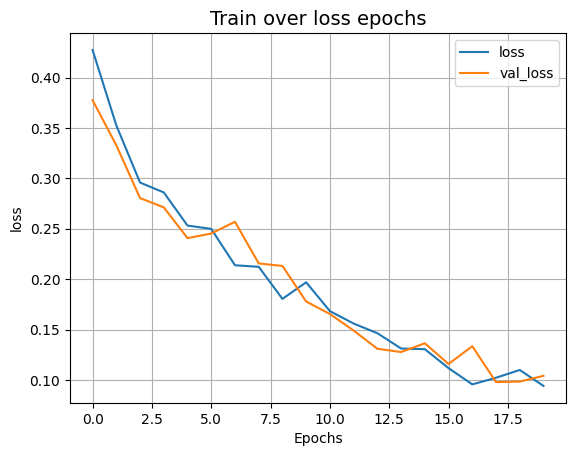

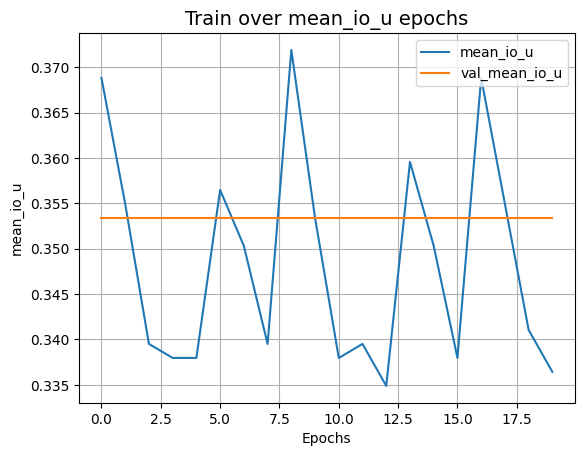

In [23]:
epochs = 20

callbacks = [
     ModelCheckpoint(check_path, monitor='val_mean_io_u', save_best_only=True, verbose=0),
]

history = model.fit(
    train_DG,
    steps_per_epoch=nb_train_samples,
    validation_data=val_DG,#add validation data                    
    validation_steps=nb_validation_samples,
    epochs = epochs,
    #batch_size=10,
    callbacks=callbacks,
    #class_weight = {0: 0.3,
    #            1: 0.24,
    #            2: 1}
)

def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_"+item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train over {} epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()

plot_result("loss")
plot_result("mean_io_u")

In [26]:
_, mean_io_u = model.evaluate(test_DG, steps=nb_test_samples, verbose=1)
print(f"Accuracy on the test set: {round(mean_io_u *100, 2)}%")

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
c:\Users\jeday\AppData\Local\Programs\Python\Python39\lib\site-packages\transformers\tokenization_utils_base.py:2346: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


81/81 [==============================] - 228s 3s/step - loss: 0.0907 - mean_io_u: 0.3364
Accuracy on the test set: 33.64%


In [34]:
model.save(check_path)

INFO:tensorflow:Assets written to: ./model-without-empty-param-checkpoints\assets


INFO:tensorflow:Assets written to: ./model-without-empty-param-checkpoints\assets


In [12]:
model = models.load_model(check_path)

In [38]:
def preprocess_text(line):
  tokenizer = transformers.BertTokenizer.from_pretrained(
            "bert-base-uncased", do_lower_case=True
        )
  tokenized_string = tokenizer.encode_plus(
                text=line,
                add_special_tokens=True,
                max_length=max_len,
                return_attention_mask=True,
                return_token_type_ids=True,
                pad_to_max_length=True,
                return_tensors="tf"
            )
  input_ids = np.asarray(tokenized_string["input_ids"], dtype="float32")
  attention_masks = np.asarray(tokenized_string["attention_mask"], dtype="int32")
  token_type_ids = np.asarray(tokenized_string["token_type_ids"], dtype="int32")
  return [input_ids, attention_masks, token_type_ids]

print(preprocess_text("test"))


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


[array([[ 101., 3231.,  102., ...,    0.,    0.,    0.]], dtype=float32), array([[1, 1, 1, ..., 0, 0, 0]]), array([[0, 0, 0, ..., 0, 0, 0]])]


In [58]:
test_string = preprocess_text("лимфоциты %")
result = model.predict(test_string)
print(result)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


1/1 [==============================] - 1s 1s/step
[[0.22363043 0.00489546]]
